In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


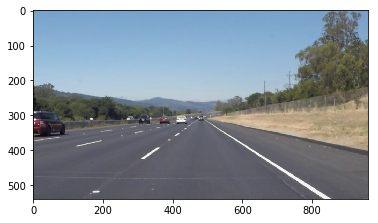

In [95]:
#reading in an image
image = mpimg.imread('solidWhiteRight.jpg')
initial_img=image

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) 
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [96]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color 
   # print (vertices)
    a=cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image,a


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
def line(lines):

    positive_slope_lines=[]
    negative_slope_lines=[]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=(y2-y1)/(x2-x1)
            if slope>0:
                positive_slope_lines.append([x1,y1,x2,y2])
                
                
                
            elif slope<0:
                negative_slope_lines.append([x1,y1,x2,y2])
                
                
            else:
                continue
         
    positive_slope_pts=np.asarray(positive_slope_lines) 
    negative_slope_pts=np.asarray(negative_slope_lines)
    return positive_slope_pts,negative_slope_pts
                
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    b=lines
    line_img = np.zeros((img.shape[0],img.shape[1],3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img,b

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.7, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [97]:
from sklearn.linear_model import LinearRegression

In [98]:
def extrapolate(pts):
    pts=pts.reshape((pts.shape[0]*pts.shape[1],1))
    
    clf = LinearRegression().fit(pts[0::2],pts[1::2])
    m=clf.coef_[0]
    c=clf.intercept_
    return m,c

    

In [99]:
def make_lanes(img,m,c):
    pts=[]
    pts.append([int((540-c)/m),540,int((320-c)/m),320])
    pts=np.asarray(pts)
    pts=np.expand_dims(pts,axis=1)
    
    draw_lines(img,pts,[255,0,0],10)

In [100]:
def detect_lanes_video(image):
    imshape = image.shape
    


    greyscaled_image = grayscale(image)
    
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask,a = region_of_interest(edges_image, vertices)
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image,lines = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)

    

    left_line_pts,right_line_pts=line(lines)
    left_line_pt=np.expand_dims(left_line_pts,axis=1)
    right_line_pt=np.expand_dims(right_line_pts,axis=1)
    #img = np.zeros((imshape[0],imshape[1],3), dtype=np.uint8)
    #draw_lines(img,left_line_pt,[0,255,0])
    #draw_lines(img,right_line_pt,[0,0,255])

   
    
    # Combine lines image with original image
    #im = weighted_img(lines_image, image)
    ## Plot final image
    
    
    #final_image=weighted_img(img, image)
    
    m1,c1=extrapolate(right_line_pts)
    m2,c2=extrapolate(left_line_pts)
    imge = np.zeros((imshape[0],imshape[1],3), dtype=np.uint8)
    make_lanes(imge,m1,c1)
    make_lanes(imge,m2,c2)
    
    final_image=weighted_img(imge, image,0.8,0.8,0.0)
    plt.subplot(2,2,4)
    plt.imshow(final_image)
    
    return final_image
    





    


In [101]:
def detect_lanes_image(image):
    imshape = image.shape
    fig=plt.figure(figsize=(30,30))    
    ax1=fig.add_subplot(3,3,1)


    greyscaled_image = grayscale(image)
    ax1.imshow(greyscaled_image, cmap="gray")
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    ax2=fig.add_subplot(3,3,2)
    ax2.imshow(blurred_grey_image,cmap='gray')
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    ax3=fig.add_subplot(3,3,3)
    ax3.imshow(edges_image,cmap='gray')
#plt.imshow(edges_image, cmap="gray")

    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask,a = region_of_interest(edges_image, vertices)
    ax4=fig.add_subplot(3,3,4)
    ax4.imshow(a,cmap='gray')

    ax5=fig.add_subplot(3,3,5)
    ax5.imshow(edges_image_with_mask,cmap='gray')
    print (edges_image_with_mask.shape)
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image,lines = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)

    ax6=fig.add_subplot(3,3,6)
    ax6.imshow(lines_image)

    left_line_pts,right_line_pts=line(lines)
    left_line_pt=np.expand_dims(left_line_pts,axis=1)
    right_line_pt=np.expand_dims(right_line_pts,axis=1)
    img = np.zeros((imshape[0],imshape[1],3), dtype=np.uint8)
    draw_lines(img,left_line_pt,[0,255,0])
    draw_lines(img,right_line_pt,[0,0,255])

   
    
    # Combine lines image with original image
    im = weighted_img(lines_image, image)
    ## Plot final image
    ax7=fig.add_subplot(3,3,7)
    ax7.imshow(im)

    ax8=fig.add_subplot(3,3,8)
    ax8.imshow(img)
    final_image=weighted_img(img, image)
    ax9=fig.add_subplot(3,3,9)
    
    ax9.imshow(final_image)
    m1,c1=extrapolate(right_line_pts)
    m2,c2=extrapolate(left_line_pts)
    imge = np.zeros((imshape[0],imshape[1],3), dtype=np.uint8)
    make_lanes(imge,m1,c1)
    make_lanes(imge,m2,c2)
    
    final_image=weighted_img(imge, image,0.8,0.8,0.0)
    
    
    return final_image
    

(540, 960)


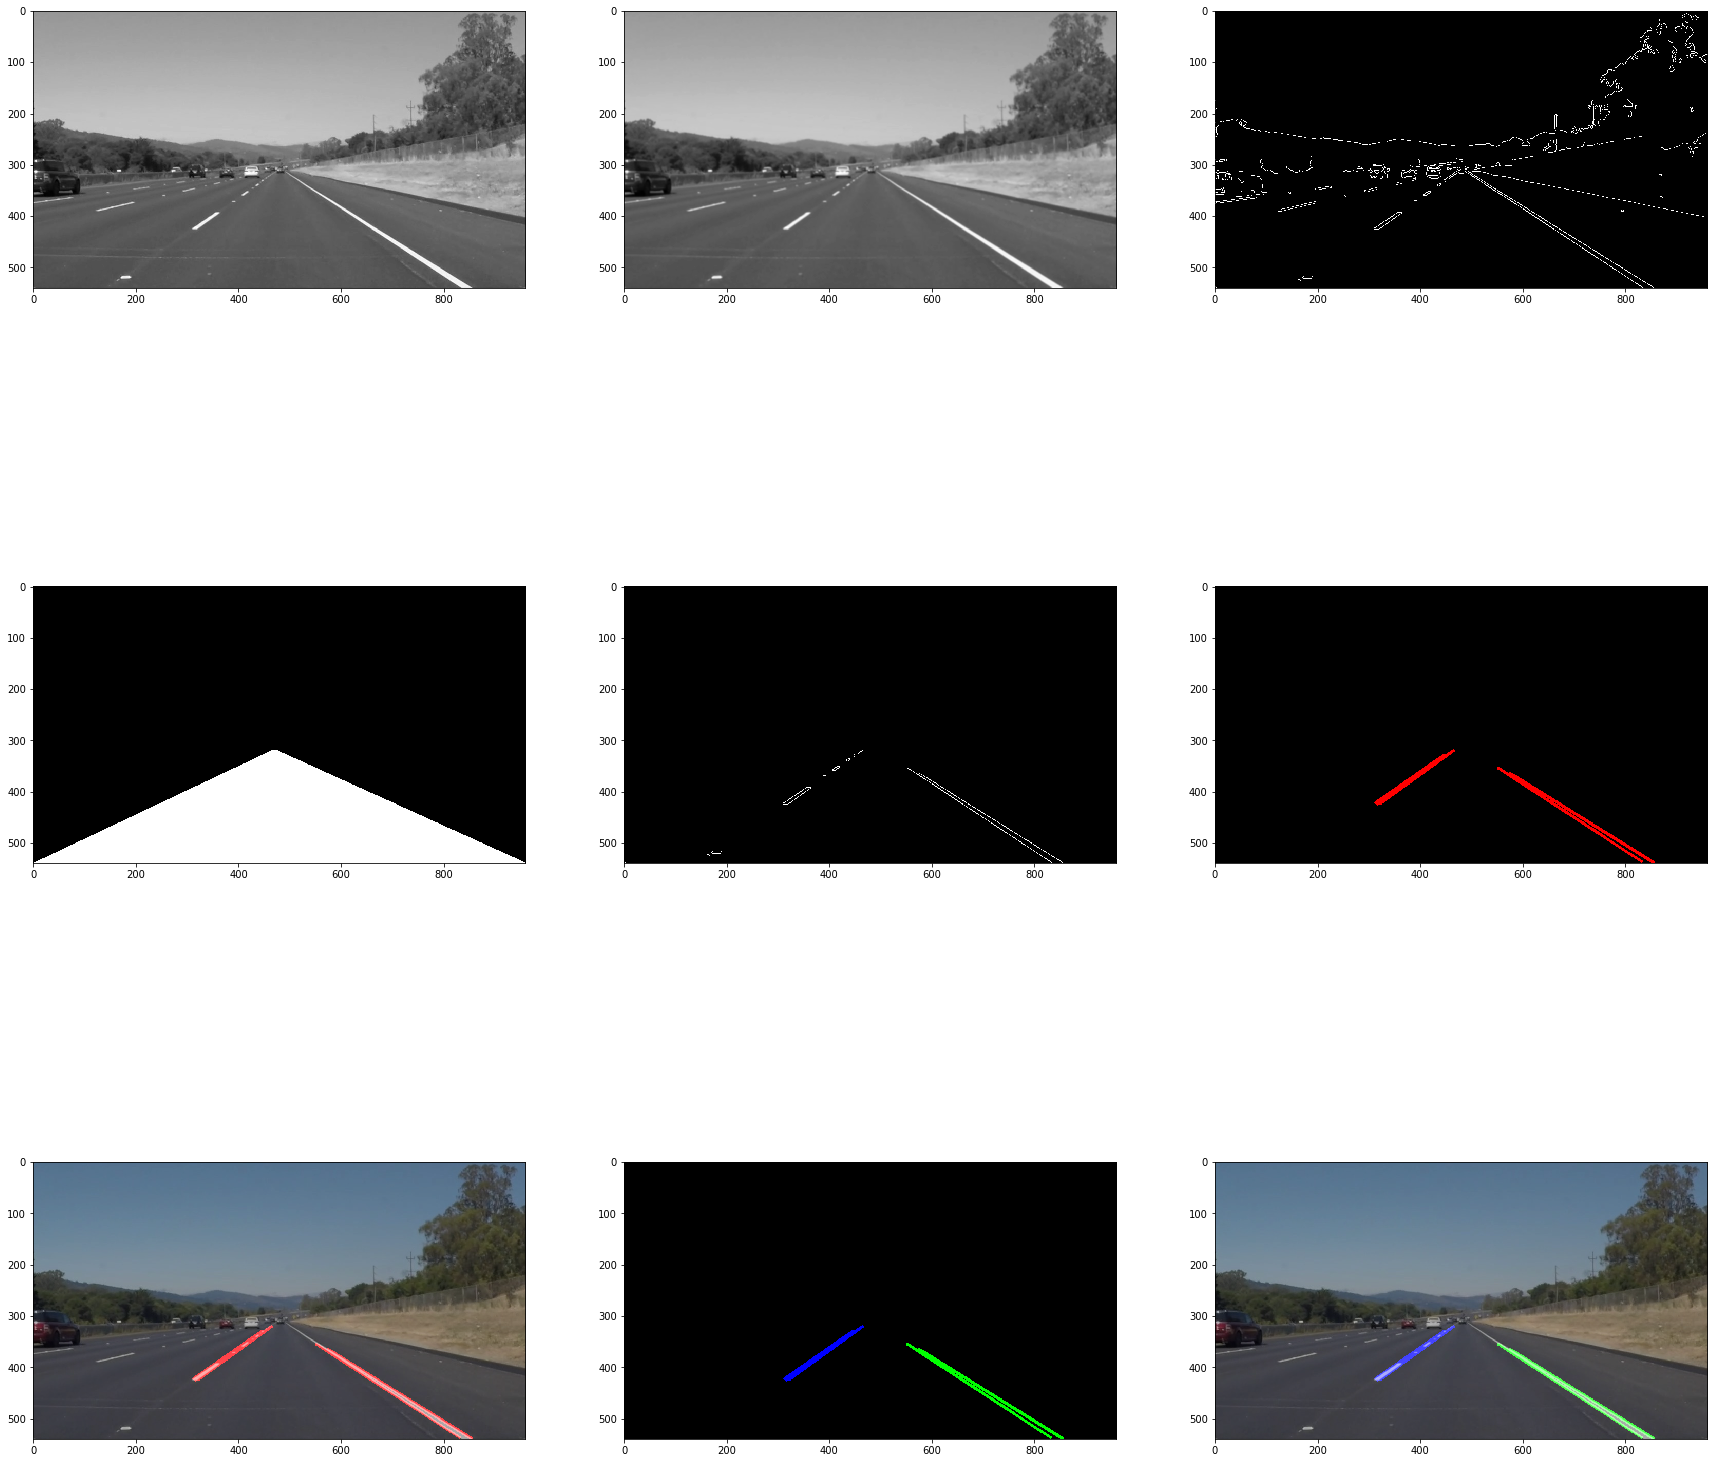

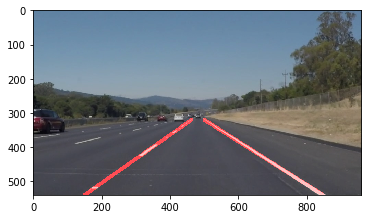

In [102]:
final=detect_lanes_image(image)
fig=plt.figure(figsize=(20,20))
ax1=fig.add_subplot(3,3,1)    # Greyscale image
ax1.imshow(final)
    

In [103]:
import imageio
#imageio.plugins.ffmpeg.download()

In [104]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML



In [105]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = detect_lanes_video(image)
    #print(result.shape)
    return result

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4



100%|█████████▉| 221/222 [00:06<00:00, 33.52it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 5.44 s, sys: 890 ms, total: 6.33 s
Wall time: 7.29 s


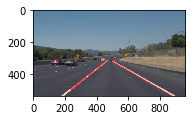

In [106]:
white_output = 'result.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [107]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))